In [1]:
%matplotlib inline

# Path management
import os
from pathlib import Path

# Get main project directory 
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [2]:
# Internal modules
from src import isuelogit as isl

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [3]:
# External modules
import sys
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# =============================================================================
# 2) NETWORK FACTORY
# =============================================================================

# Dictionary to store network objects for random networks
network_name = 'N1'

# Reporter of estimation results
estimation_reporter = isl.writer.Reporter(foldername=network_name, seed = 2022)

# Set main directory for reading and writing methods
#isl.config.set_main_dir(main_dir)

# Create Network Generator
network_generator = isl.factory.NetworkGenerator()

# Create transportation network with randomly generated adjacency matrix
random_network = network_generator.build_random_network(network_name= network_name,
                                                        nodes_range = (5,5))



Creating N1 network

Nodes: 5, Links: 11


In [5]:
# =============================================================================
# b) EXOGENOUS LINK ATTRIBUTES
# =============================================================================

# Set link level attributes

# Create data generator to generate synthetic link attributes
linkdata_generator = isl.factory.LinkDataGenerator()

# Generate synthetic link attributes
link_features_df = linkdata_generator.simulate_features(
    links = random_network.links,
    features_Z= ['c','s'],
    option = 'continuous',
    range = (0,1))

# - Number of attributes that will be set to 0, which moderate sparsity: with 20 at least, we observe benefits of regularize
n_sparse_features = 2 #10 #20 #50
sparse_features_labels = ['k' + str(i) for i in np.arange(0, n_sparse_features)]

sparse_features_df = linkdata_generator.simulate_features(
    links = random_network.links,
    features_Z= sparse_features_labels,
    option = 'continuous',
    range = (-1,1))

#Merge data with existing dataframe
link_features_df = link_features_df.merge(sparse_features_df,
                                          left_on = 'link_key',
                                          right_on = 'link_key')

#Load features data
random_network.load_features_data(linkdata = link_features_df)

In [6]:
# =============================================================================
# b) ENDOGENOUS LINK ATTRIBUTES
# =============================================================================

# Set random link performance functions
bpr_parameters_df = linkdata_generator.generate_random_bpr_parameters(
    links_keys = random_network.links_keys)
random_network.set_bpr_functions(bprdata = bpr_parameters_df)

In [7]:
# =============================================================================
# c) BEHAVIORAL PARAMETERS AND UTILITY FUNCTIONS
# =============================================================================

utility_parameters = isl.estimation.Parameters(features_Y=['tt'],
                                               # features_Z= [],
                                               # features_Z= ['c'],
                                               true_values={'tt': -1, 'c': -6},
                                               # initial_values =  {'tt': -1, 'c': -6},
                                               # initial_values =  {'tt': 0}
                                               )

utility_function = isl.estimation.UtilityFunction(utility_parameters)


# Add sparse features
utility_function.add_sparse_features(Z = sparse_features_labels)

In [8]:
# =============================================================================
# c) OD
# =============================================================================

# Create OD generator (for random networks only)
od_generator = isl.factory.ODGenerator()

Q = od_generator.generate_Q(network = random_network,
                            min_q = 0, max_q = 100,
                            cutoff = 1, sparsity_Q = 0.2)

# Load O-D matrix
random_network.load_OD(Q  = Q)

Generating matrix Q
The expected number of matrix entries to fill out is 20. Sparsity: 20%
20 entries were filled out. Sparsity: 20%
Matrix Q (5, 5) generated in 0.0[s]
1032.0 trips were loaded among 20 o-d pairs


In [9]:
# =============================================================================
# d) PATHS
# =============================================================================

# Create path generator
paths_generator = isl.factory.PathsGenerator()

# Generate and Load paths in network
paths_generator.load_k_shortest_paths(network = random_network, k=5, update_incidence_matrices=False, silent_mode = True)
# paths_generator.read_paths(network=random_network, update_incidence_matrices=True)

Generating at most 5 paths per od
75 paths were generated among 20 od pairs in 0.0 [s]
75 paths were loaded in the network
Updating incident matrices
Matrix D (11, 75) generated in 0.0[s]00.0% 
Matrix M (20, 75) generated in 0.0[s]00.0% 
Matrix C (75, 75) generated in 0.0[s]


In [10]:
# =============================================================================
# j) GENERATION OF SYNTHETIC COUNTS
# =============================================================================

# Generate synthetic traffic counts

counts, counts_withdraw = linkdata_generator.simulate_counts(
    equilibrator = isl.equilibrium.LUE_Equilibrator(
        network = random_network,
        paths_generator = paths_generator,
        uncongested_mode = False,
        max_iters = 100,
        method = 'fw',
        iters_fw = 100,
        # path_size_correction = 2
    ),
    utility_function=utility_function,
    noise_params = {'mu_x': 0, 'sd_x': 0},
    coverage = 0.9
)

random_network.load_traffic_counts(counts=counts)



Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -3,112.32
Final Fisk Objective: -3,112.32
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 0.1 [s]
Ratio of counts versus capacity: 11.0%
Proportion of links over capacity: 0.0%
Normalized RMSE: 0.0


In [11]:
# =============================================================================
# 3) DESCRIPTIVE STATISTICS
# =============================================================================

# =============================================================================
# a) Networks topology
# =============================================================================

isl.descriptive_statistics.summary_table_networks([random_network])

,network,nodes,links,ods,paths
0,N1,5,11,20,75


In [12]:
# =============================================================================
# c) Links features and counts
# =============================================================================

summary_table_links_df = isl.descriptive_statistics.summary_table_links(links=random_network.links)

estimation_reporter.write_table(df = summary_table_links_df, filename = 'summary_table_links.csv', float_format = '%.3f')

summary_table_links_df

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_id,link_type,c,s,k0,k1,alpha,beta,tf,k
0,"(0, 2, 0)",0,NaN,1800,0.4,NaN,None,[],LWRLK,0.879469,0.884703,0.447036,-0.755968,0.15,4.0,0.4,1800.0
1,"(0, 4, 0)",0,NaN,1800,0.5,NaN,None,[],LWRLK,0.327931,0.128586,0.544218,0.151808,0.15,4.0,0.5,1800.0
2,"(1, 0, 0)",1,284.9,1800,0.3,NaN,None,[],LWRLK,0.137849,0.726442,-0.241985,-0.780263,0.15,4.0,0.3,1800.0
3,"(1, 2, 0)",1,169.0,1800,0.5,NaN,None,[],LWRLK,0.412108,0.412989,-0.247736,0.477038,0.15,4.0,0.5,1800.0
4,"(2, 3, 0)",1,191.2,1800,0.1,NaN,None,[],LWRLK,0.313607,0.569298,0.691593,-0.437715,0.15,4.0,0.1,1800.0
5,"(2, 4, 0)",1,236.7,1800,0.5,NaN,None,[],LWRLK,0.825173,0.935564,0.127995,0.803699,0.15,4.0,0.5,1800.0
6,"(3, 0, 0)",1,200.7,1800,0.4,NaN,None,[],LWRLK,0.121566,0.515330,0.124744,0.999129,0.15,4.0,0.4,1800.0
7,"(3, 1, 0)",1,207.9,1800,0.3,NaN,None,[],LWRLK,0.584616,0.003561,0.142321,0.816157,0.15,4.0,0.3,1800.0
8,"(3, 2, 0)",1,96.1,1800,0.1,NaN,None,[],LWRLK,0.972300,0.205324,-0.559823,0.952850,0.15,4.0,0.1,1800.0
9,"(4, 1, 0)",1,171.0,1800,0.4,NaN,None,[],LWRLK,0.854277,0.644501,-0.467442,-0.483122,0.15,4.0,0.4,1800.0


In [13]:
# =============================================================================
# 5) BILEVEL OPTIMIZATION
# =============================================================================

# Random initilization of initial estimate
# utility_function.random_initializer((-0.1,0.1))

equilibrator_norefined = isl.equilibrium.LUE_Equilibrator(
    network = random_network,
    paths_generator=paths_generator,
    uncongested_mode = False,
    max_iters = 100,
    method = 'fw',
    iters_fw = 100,
#     column_generation = {'n_paths': 3,
#                          'ods_coverage': 0.07,
#                          # 'ods_sampling':'random',
#                          # 'paths_selection': 3
#                          },
    path_size_correction = 2
)

outer_optimizer_norefined = isl.estimation.OuterOptimizer(
    method= 'ngd',
    iters= 1,  # 10
    eta= 5e-1,
    # path_size_correction = 1
)


learner_norefined = isl.estimation.Learner(
    equilibrator = equilibrator_norefined,
    outer_optimizer= outer_optimizer_norefined,
    utility_function = utility_function,
    network = random_network,
    name = 'norefined'
)

equilibrator_refined = isl.equilibrium.LUE_Equilibrator(
    network = random_network,
    paths_generator=paths_generator,
    uncongested_mode = True,
    max_iters = 100,
    method = 'fw',
    iters_fw = 100,
    # column_generation = {'n_paths': 2, 'ods_coverage': 1, 'paths_selection': 2},
    path_size_correction = 2
)

outer_optimizer_refined = isl.estimation.OuterOptimizer(
    # method='gauss-newton',
    method='lm',
    # eta=5e-2,
    # lmabda_lm = 1e0,
    iters=10,
    # path_size_correction = 1
)

learner_refined = isl.estimation.Learner(
    network=random_network,
    equilibrator=equilibrator_refined,
    outer_optimizer=outer_optimizer_refined,
    utility_function=utility_function,
    name = 'refined'
)


In [14]:
# =============================================================================
# BENCHMARK PREDICTIONS
# =============================================================================

# Naive prediction using mean counts
mean_counts_prediction_loss, mean_count_benchmark_model, \
    = isl.estimation.mean_count_prediction(x_bar=np.array(list(counts.values()))[:, np.newaxis])

print('\nObjective function under mean count prediction: ' + '{:,}'.format(round(mean_counts_prediction_loss, 1)))

# Naive prediction using uncongested network
equilikely_prediction_loss, predicted_counts_equilikely = isl.estimation.loss_counts_equilikely_choices(
    network = random_network,
    equilibrator=equilibrator_refined,
    counts=random_network.counts_vector,
    utility_function=utility_function
)

print('Objective function under equilikely route choices: ' + '{:,}'.format(round(equilikely_prediction_loss, 1)))


Objective function under mean count prediction: 22,323.9
Objective function under equilikely route choices: 6,990.8


In [15]:
# =============================================================================
# 3d) ESTIMATION
# =============================================================================

# ii) NO REFINED OPTIMIZATION AND INFERENCE WITH FIRST ORDER OPTIMIZATION METHODS

# bilevel_estimation_norefined = isl.estimation.Learner(config.theta_0)

print('\nStatistical Inference in no refined stage')

learning_results_norefined, inference_results_norefined, best_iter_norefined = \
    learner_norefined.statistical_inference(h0 = 0, bilevel_iters = 10, alpha = 0.05, iteration_report = False)

# theta_norefined = learning_results_norefined[best_iter_norefined]['theta']
theta_norefined = learning_results_norefined[list(learning_results_norefined.keys())[-1]]['theta']

# paths_generator.write_paths(network=random_network, overwrite_input=True)


Statistical Inference in no refined stage

Bilevel optimization for N1 network 

Initial theta: {'tt': '0.0E+00', 'k0': '0.0E+00', 'k1': '0.0E+00'}
Initial objective: 6,991
Initial RMSE: 27.9
Initial Normalized RMSE: 0.14

Iterations: |████████████████████| 10/10
Summary results of bilevel optimization
best iter: 9
best theta: {'tt': '-6.4E-01', 'k0': '1.6E-01', 'k1': '1.8E-01'}
best objective_value: 4,876
Final best objective improvement: 30.25%
Final best objective improvement value: 2,114.9
Best RMSE: 23.3
Best Normalized RMSE: 0.117
Total time: 0.6 [s]

Performing hypothesis testing (H0: theta = 0, alpha = 0.05)
Hessian approximated as J^T J

Summary of parameters: 
 parameter    est              CI  width_CI  t-test  p-value
       tt -0.639 [-1.361, 0.082]     0.721  -2.169    0.073
       k0  0.157 [-0.234, 0.549]     0.391   0.985    0.363
       k1  0.179 [-0.129, 0.487]     0.308   1.424    0.204

Computing F-test

Summary of model: 
     F  critical-F     p  n  dof_m1  dof_

In [16]:
print('\nStatistical Inference in refined stage')

learner_refined.utility_function.parameters.initial_values = theta_norefined

learning_results_refined, inference_results_refined, best_iter_refined = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10,alpha=0.05, iteration_report = True)


Statistical Inference in refined stage

Bilevel optimization for N1 network 

Iteration : 1/10

Initial theta: {'tt': '-7.4E-01', 'k0': '-2.8E-02', 'k1': '-2.8E-01'}

SUE via fw (max iters: 0)
Performed path size correction with factor 2
Initial objective: 7,119
Initial RMSE: 28.1
Initial Normalized RMSE: 0.141

Iteration : 2/10

Learning  params via lm (10 iters )

Damping factors: ['1.0E-02', '5.0E-03']
theta: {'tt': '-6.9E-01', 'k0': '6.8E-02', 'k1': '-5.9E-03'}
time: 0.0[s]

SUE via fw (max iters: 0)
Performed path size correction with factor 2

Time current iteration: 0.0 [s]
Current objective_value: 334
Current objective improvement: 95.31%
Current RMSE: 6.1
Current Normalized RMSE: 0.031
Marginal objective improvement: 95.31%
Marginal objective improvement value: 6,785.6


Iteration : 3/10

Learning  params via lm (10 iters )

Damping factors: ['1.0E-02', '5.0E-03']
theta: {'tt': '-7.0E-01', 'k0': '6.7E-02', 'k1': '-1.4E-02'}
time: 0.0[s]

SUE via fw (max iters: 0)
Performed pa

In [17]:
# =============================================================================
# 6) REPORTS
# =============================================================================

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined,
    theta_refined=learning_results_refined[best_iter_refined]['theta'],
    best_objective_norefined = learning_results_norefined[best_iter_norefined]['objective'],
    best_objective_refined = learning_results_refined[best_iter_refined]['objective'],
    mean_count=mean_count_benchmark_model,
    mean_counts_prediction_loss = mean_counts_prediction_loss,
    equilikely_prediction_loss = equilikely_prediction_loss
)

# Summary with most relevant options, prediction error, initial parameters, etc
estimation_reporter.write_estimation_report(
    network=random_network,
    learners=[learner_norefined, learner_refined],
    linkdata_generator=linkdata_generator,
    utility_function=utility_function)

# Write tables with results on learning and inference
estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined,
    results_refined=learning_results_refined,
    network = random_network,
    utility_function = utility_function,
    simulated_data = True)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined,
    results_refined=inference_results_refined,
    float_format = '%.3f')

In [18]:
# =============================================================================
# VISUALIZATIONS
# =============================================================================

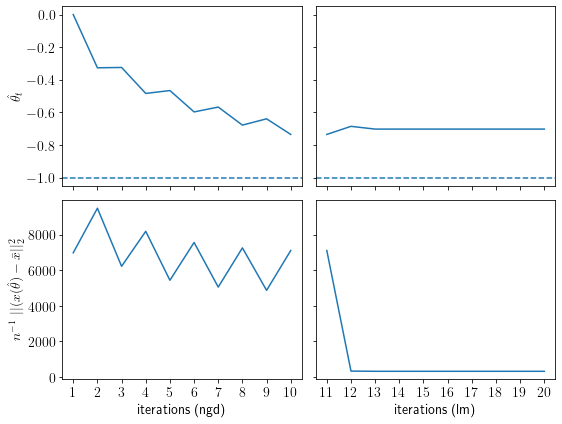

In [19]:
#plt.rcParams['figure.figsize'] = [8, 6]

# Convergence

results_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined
                                            , results_refined=learning_results_refined)

fig = isl.visualization.Artist().convergence(
    results_norefined_df=results_df[results_df['stage'] == 'norefined'],
    results_refined_df=results_df[results_df['stage'] == 'refined'],
    simulated_data= True,
    filename='convergence_' + random_network.key,
    methods=[outer_optimizer_norefined.options['method'], outer_optimizer_refined.options['method']],
    theta_true = utility_function.parameters.true_values,
    folder = estimation_reporter.dirs['estimation_folder']
)

plt.show()

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'bilevel_optimization_convergence.pdf',
            pad_inches=0.1, bbox_inches="tight")

plt.close(fig)

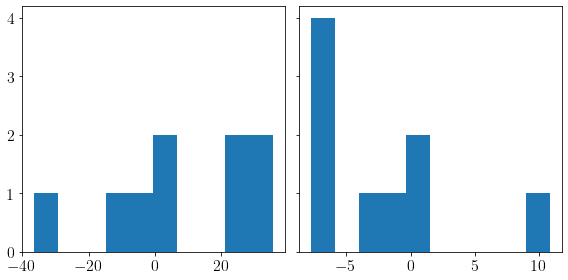

In [20]:
# Distribution of errors across link counts
best_x_norefined = np.array(list(learning_results_norefined[best_iter_refined]['x'].values()))[:, np.newaxis]
best_x_refined = np.array(list(learning_results_refined[best_iter_refined]['x'].values()))[:, np.newaxis]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8, 4))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(isl.estimation.error_by_link(observed_counts=random_network.counts_vector, predicted_counts=best_x_norefined))
axs[1].hist(isl.estimation.error_by_link(observed_counts=random_network.counts_vector, predicted_counts=best_x_refined))

for axi in [axs[0], axs[1]]:
    axi.tick_params(axis='x', labelsize=16)
    axi.tick_params(axis='y', labelsize=16)
    
plt.show()

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'distribution_predicted_count_error.pdf',
            pad_inches=0.1, bbox_inches="tight")
plt.close(fig)